<h2><b><center>Trabalho 6: Descritor HOG</center></b></h2>

> Obs.: Vimos que o histograma do HOG pode ser representado de várias formas, sendo que alguns consideram apenas a orientação, outros apenas a magnitude e outros os dois. Dessa forma, optamos por retornar dois histogramas na nossa função, um de orientação e outro de magnitude.



**Importações.**

In [1]:
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import sys
import itertools
import random
import math

In [2]:
contValues = 0

**Leitura da imagem e conversão pra níveis de cinza e valores inteiros.**

/home/vitoria/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


(670, 391)


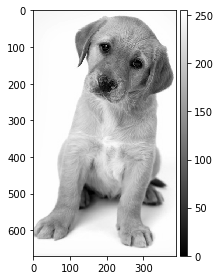

In [3]:
img = imread('dog.jpeg')
#resized_img = resize(img, (128,64))
resized_img = img.copy()
resized_img = rgb2gray(resized_img)*255
resized_img = resized_img.astype(int)
imshow(resized_img, cmap='gray')
print(resized_img.shape)

**Cálculo da magnitude.**

In [4]:
def magnitude(Gx, Gy):
  mag = (Gx**2 + Gy**2)**(1/2)
  return mag

**Cálculo da orientação.**

In [5]:
def orientacao(Gx, Gy):
  return np.arctan(Gx/Gy)

**Cálculo de normalização do bloco.**

In [6]:
def normalize(hist):
  hist = np.asarray(hist)
  k = (np.sum(hist**2))**(1/2)
  hist = hist/k
  return hist.tolist()

**Essa função calcula um histograma de magnitude e um de orientação para uma célula passada por parâmetro.**

In [7]:
def histogramaCel(celula):
  histOri = []
  histMag = []
  global contValues
  for i in range(1, celula.shape[0]-1):
      for j in range(1, celula.shape[1]-1):
          Gx = celula[i][j+1]-celula[i][j-1]
          Gy = celula[i-1][j]-celula[i+1][j]
          mag = magnitude(Gx, Gy)
          contValues += 1
          ori = orientacao(Gx, Gy)
          if(math.isnan(ori)):
            histOri.append(0)
          else:
            histOri.append(ori)
          if(math.isnan(mag)):
            histMag.append(0)
          else:
            histMag.append(mag)
          
  return histOri, histMag

#print(np.asarray(histogramaCel(arr)))

**Essa função serve basicamente para realizar um mapeamento das células de cada bloco, ou seja, cada posição de pixel das células é numerada com um identificador específico, para saber que aquela região de pixels (células) pertence a um determinado bloco.**

In [8]:
def mapea(img, cell, block):
  teste = img.copy()
  inil = 0
  fiml = img.shape[0]//block[0]
  contB = 1
  for i in range(block[0]):
    inic = 0
    #fimc = cell[1]*block[1]
    fimc = img.shape[1]//block[1]
    for j in range(block[1]):
      teste[inil:fiml,inic:fimc] = contB
      contB += 1
      inic += (img.shape[1]//block[1])
      fimc += (img.shape[1]//block[1])
    inil += (img.shape[0]//block[0])
    fiml += (img.shape[0]//block[0])

  return teste

**Essa é a principal função, pois aqui eu divido as células de acordo com o shape especificado e calculo os histogramas para cada célula. Além disso, essa função agrupa na mesma lista os histogramas que pertencem ao mesmo bloco, graças à variável idBlock, obtida a partir do mapeamento feito pela função anterior. O retorno são três listas: uma com todas as células, uma com o histograma de orientação e a outra com o histograma de magnitude.**

In [9]:
def hog(img, cell, block):
  corte = []
  l = 0
  mapeamentos = mapea(img, cell, block)

  blocksOri = [[]]*(block[0]*block[1])
  blocksMag = [[]]*(block[0]*block[1])

  for i in range(int(img.shape[0]/cell[0])):
    c = 0
    for j in range(int(img.shape[1]/cell[1])):
      celula = img[l:l+cell[0], c:c+cell[1]]
      corte.append(celula)
        
      #calculando histogramas
      histOri, histMag = histogramaCel(celula)
        
      #encontrando o id do bloco à qual a célula pertence
      idBlock = random.choice((mapeamentos[l:l+cell[0], c:c+cell[1]]).reshape(-1))
      idBlock = int(idBlock)
    
      if(i == 0) and (j == 0):
        blocksOri[idBlock-1] = histOri
        blocksMag[idBlock-1] = histMag
        #print(blocksMag[idBlock-1])
      else:
        #print('idBlock: {}'.format(idBlock-1))
        blocksOri[idBlock-1] += histOri
        blocksMag[idBlock-1] += histMag
      c+=cell[1]
    l+=cell[0]
    
  print('Quantidade de pixels na imagem: {}'.format(img.shape[0]*img.shape[1]))
  #print('Histograma de orientações, tamanho final de cada bloco: {}, {}, {} e {}'.format(len(blocksOri[0]), len(blocksOri[1]), len(blocksOri[2]), len(blocksOri[3])))
  #print('Histograma de magnitude, tamanho final de cada bloco: {}, {}, {} e {}'.format(len(blocksMag[0]), len(blocksMag[1]), len(blocksMag[2]), len(blocksMag[3])))
  return corte, blocksOri, blocksMag

**Essa função implementa a execução do HOG. As duas repetições while servem para garantir que o shape da imagem será proporcional aos parâmetros de entrada. Se por acaso houver necessidade de redimensionar a imagem, os pixels que sobram são preenchidos com 1. Por fim, a função realiza a normalização de cada um dos blocos para, enfim, concatená-los, transformando-os em apenas um array de cada tipo (orientação e magnitude).**

In [10]:
def runHists(arr, cell, block):
  lin = arr.shape[0]
  col = arr.shape[1]

  while(not((lin%cell[0] == 0) and ((lin/cell[0])%block[0] == 0))):
    lin += 1

  while(not((col%cell[1] == 0) and ((col/cell[1])%block[1] == 0))):
    col += 1

  #print(lin, col)

  new = np.ones([lin, col])
  new[0:arr.shape[0],0:arr.shape[1]] = arr
  #print(new.shape)

  corte, blocksOri, blocksMag = hog(new, cell, block)
  array_cortes = np.asarray(corte)

  # hog_final_ori = normalize(blocksOri[0])
  # hog_final_mag = normalize(blocksMag[0])
  hog_final_ori = []
  hog_final_mag = []
  merged1 = []
  merged2 = []

  for i in range(len(blocksOri)):
    #hog_final_ori += normalize(blocksOri[i])
    #hog_final_mag += normalize(blocksMag[i])
    hog_final_ori.append(normalize(blocksOri[i]))
    merged1 = list(itertools.chain(*hog_final_ori))
    hog_final_mag.append(normalize(blocksMag[i]))
    merged2 = list(itertools.chain(*hog_final_mag))

  #print(array_cortes.shape)
  global contValues
  #print('contValues = {}'.format(contValues))
  print('\n+-------------------------- HOG --------------------------+')
  print('Tamanho final do histograma (blocos) HOG orientações: {}'.format(len(hog_final_ori)))
  print('Tamanho final do histograma (blocos) HOG magnitudes: {}'.format(len(hog_final_mag)))
  print('Tamanho do Merged1 (HOG final orientações): {}'.format(len(merged1)))
  print('Tamanho do Merged2 (HOG final magnitudes): {}'.format(len(merged2)))

  return merged1, merged2

**Calculando de fato os histogramas, pois agora estamos levando em consideração as frequências.**<br>
**hog1 => histograma de orientações**<br>
**hog2 => histograma de magnitudes**<br>
**Na posição 1 estão os valores e na posição 0 as frequências.**

In [11]:
from collections import Counter

hog_final_ori, hog_final_mag = runHists(resized_img, [8,8], [2,2])

hog1 = []
hog1.append(list(Counter(hog_final_ori).values()))
hog1.append(list(Counter(hog_final_ori).keys()))

hog2 = []
hog2.append(list(Counter(hog_final_ori).values()))
hog2.append(list(Counter(hog_final_ori).keys()))

print('Tamanho dos histogramas finais: {} e {}'.format(len(hog1[0]), len(hog2[0])))
print('+---------------------------------------------------------+')

/home/vitoria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/vitoria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


Quantidade de pixels na imagem: 268800

+-------------------------- HOG --------------------------+
Tamanho final do histograma (blocos) HOG orientações: 4
Tamanho final do histograma (blocos) HOG magnitudes: 4
Tamanho do Merged1 (HOG final orientações): 378000
Tamanho do Merged2 (HOG final magnitudes): 378000
Tamanho dos histogramas finais: 4503 e 4503
+---------------------------------------------------------+
